#### Part 1: Load Pretrained Word2Vec Model and Find Similar Words

**Code to Load the Model and Find Similar Words**

In [2]:
import gensim.downloader as api

In [3]:
# Load the pretrained Word2Vec model
wv_pretrained = api.load("word2vec-google-news-300")

In [4]:
# List of words to find similar words for
words = ["king", "computer", "car", "apple", "university"]

In [5]:
# Find and print the most similar words for each word in the list
for word in words:
    similar_words = wv_pretrained.most_similar(word, topn=5)
    print(f"Top 5 words similar to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")
    print()

Top 5 words similar to 'king':
  kings: 0.7138
  queen: 0.6511
  monarch: 0.6413
  crown_prince: 0.6204
  prince: 0.6160

Top 5 words similar to 'computer':
  computers: 0.7979
  laptop: 0.6640
  laptop_computer: 0.6549
  Computer: 0.6473
  com_puter: 0.6082

Top 5 words similar to 'car':
  vehicle: 0.7821
  cars: 0.7424
  SUV: 0.7161
  minivan: 0.6907
  truck: 0.6736

Top 5 words similar to 'apple':
  apples: 0.7204
  pear: 0.6451
  fruit: 0.6410
  berry: 0.6302
  pears: 0.6134

Top 5 words similar to 'university':
  universities: 0.7004
  faculty: 0.6781
  unversity: 0.6758
  undergraduate: 0.6587
  univeristy: 0.6585



**Analogies**

In [6]:
analogies = [
    ("king", "man", "woman", "queen"),
    ("Paris", "France", "Germany", "Berlin"),
    ("Microsoft", "Windows", "Apple", "Mac"),
]

In [7]:
# Perform and print the analogy tests
for a, b, c, d in analogies:
    result = wv_pretrained.most_similar(positive=[a, c], negative=[b])
    print(f"Result for {a} - {b} + {c} ≈ {d}:")
    for word, similarity in result:
        print(f"  {word}: {similarity:.4f}")
    print()

Result for king - man + woman ≈ queen:
  queen: 0.7118
  monarch: 0.6190
  princess: 0.5902
  crown_prince: 0.5499
  prince: 0.5377
  kings: 0.5237
  Queen_Consort: 0.5236
  queens: 0.5181
  sultan: 0.5099
  monarchy: 0.5087

Result for Paris - France + Germany ≈ Berlin:
  Berlin: 0.7644
  Frankfurt: 0.7330
  Dusseldorf: 0.7009
  Munich: 0.6774
  Cologne: 0.6470
  Düsseldorf: 0.6400
  Stuttgart: 0.6361
  Munich_Germany: 0.6238
  Budapest: 0.6193
  Hamburg: 0.6169

Result for Microsoft - Windows + Apple ≈ Mac:
  Apple_Computer: 0.6469
  Apple_NSDQ_AAPL: 0.6298
  Apple_AAPL: 0.6296
  Google: 0.6181
  Apple_NASDAQ_AAPL: 0.6131
  Apple_Nasdaq_AAPL: 0.6031
  Steve_Jobs: 0.5939
  Apple_AAPL_Fortune: 0.5575
  Apple_Inc_AAPL.O: 0.5512
  Apple_nasdaq_AAPL: 0.5483



### Part 2: Build a Movie Review Sentiment Classifier using Word2Vec

**Load the Dataset and Perform Text EDA**

In [8]:
import pandas as pd

In [9]:
# Load the dataset
IMDB = ('/Users/fariddamania/Downloads/SEM VII/NLP/Dataset/IMDB Dataset.csv')
reviews = pd.read_csv(IMDB)

In [10]:
reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
# Perform basic EDA
print(reviews.head())
print(reviews.info())
print(reviews['sentiment'].value_counts())
print(reviews.isnull().sum())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
review       0
sentiment    0
dtype: int64


In [12]:
# Distribution of review lengths
review_lengths = reviews['review'].apply(lambda x: len(x.split()))
print(review_lengths.describe())

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review, dtype: float64


In [13]:
import matplotlib.pyplot as plt

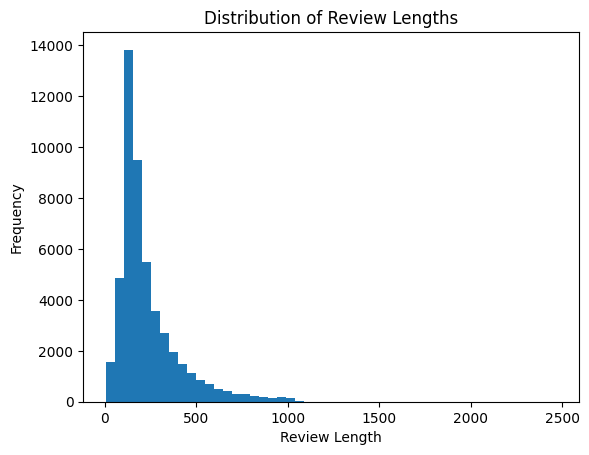

In [14]:
# Plot distribution of review lengths
plt.hist(review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

**Clean the Text**

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import os

In [16]:
stop_words = set(stopwords.words('english'))

In [17]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text.lower())  # Tokenize and lower case
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

In [18]:
reviews['cleaned_review'] = reviews['review'].apply(clean_text)

**Train Skip-gram and CBOW Models**

In [19]:
from gensim.models import Word2Vec

In [20]:
# Prepare data for Word2Vec
sentences = reviews['cleaned_review'].tolist()

In [21]:
# Train a Skip-gram model
skipgram = Word2Vec(
    sentences=sentences,
    sg=1,
    vector_size=50,
    window=5,
    min_count=1,
    workers=4
)

In [22]:
# Train a CBOW model
cbow = Word2Vec(
    sentences=sentences,
    sg=0,
    vector_size=50,
    window=5,
    min_count=1,
    workers=4
)

**Train Models Using Pretrained Word2Vec Vectors**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(reviews['review'], reviews['sentiment'], test_size=0.3, random_state=42)

In [25]:
# Using Skip-gram vectors
model_skipgram = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_skipgram.fit(X_train, y_train)
y_pred_skipgram = model_skipgram.predict(X_test)
print("Skip-gram Model Performance:")
print(classification_report(y_test, y_pred_skipgram))

Skip-gram Model Performance:
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      7411
    positive       0.89      0.91      0.90      7589

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



In [26]:
# Using CBOW vectors
model_cbow = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_cbow.fit(X_train, y_train)
y_pred_cbow = model_cbow.predict(X_test)
print("CBOW Model Performance:")
print(classification_report(y_test, y_pred_cbow))


CBOW Model Performance:
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      7411
    positive       0.89      0.91      0.90      7589

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



**Improve Model Performance and Report Metrics**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(reviews['review'], reviews['sentiment'], test_size=0.3, random_state=42)


In [29]:
# Function to get metrics from classification report
def get_metrics(y_test, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    return precision, recall, f1

In [30]:
# Using Skip-gram vectors
model_skipgram = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_skipgram.fit(X_train, y_train)
y_pred_skipgram = model_skipgram.predict(X_test)
precision_skipgram, recall_skipgram, f1_skipgram = get_metrics(y_test, y_pred_skipgram)
print("Skip-gram Model Performance:")
print(f"Precision: {precision_skipgram}, Recall: {recall_skipgram}, F1 Score: {f1_skipgram}")

Skip-gram Model Performance:
Precision: 0.9004490289479259, Recall: 0.9003333333333333, F1 Score: 0.9003138063351918


In [31]:
# Using CBOW vectors
model_cbow = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_cbow.fit(X_train, y_train)
y_pred_cbow = model_cbow.predict(X_test)
precision_cbow, recall_cbow, f1_cbow = get_metrics(y_test, y_pred_cbow)
print("CBOW Model Performance:")
print(f"Precision: {precision_cbow}, Recall: {recall_cbow}, F1 Score: {f1_cbow}")

CBOW Model Performance:
Precision: 0.9004490289479259, Recall: 0.9003333333333333, F1 Score: 0.9003138063351918


In [32]:
# Using Pretrained Word2Vec vectors
model_pretrained = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_pretrained.fit(X_train, y_train)
y_pred_pretrained = model_pretrained.predict(X_test)
precision_pretrained, recall_pretrained, f1_pretrained = get_metrics(y_test, y_pred_pretrained)
print("Pretrained Word2Vec Model Performance:")
print(f"Precision: {precision_pretrained}, Recall: {recall_pretrained}, F1 Score: {f1_pretrained}")

Pretrained Word2Vec Model Performance:
Precision: 0.9004490289479259, Recall: 0.9003333333333333, F1 Score: 0.9003138063351918
